# How to use `indigopy`

Example code for how to use the `indigopy` package. The sample data used in this example notebook is derived from the [INDIGO](https://doi.org/10.1007/978-1-4939-8891-4_13), [INDIGO-MTB](https://doi.org/10.1128/mbio.02627-19), and [MAGENTA](https://doi.org/10.1371/journal.pcbi.1006677) publications.  

## Set up environment

In [1]:
# Import dependencies
import pandas as pd
from scipy.stats import spearmanr
from sklearn.metrics import r2_score, classification_report
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt

# Import package functions
from indigopy.core import load_sample, featurize, classify

## Example: *E. coli*

The following analysis and results were originally reported in the [INDIGO](https://doi.org/10.1007/978-1-4939-8891-4_13) paper.  
- **Training dataset**: 105 two-way interactions between 15 antibiotics  
- **Testing dataset**: 66 two-way interactions between the 15 antibiotics in the training set + 4 new antibiotics  

In [2]:
# Load sample data
sample = load_sample('ecoli')

# Define input arguments
key             = sample['key']
profiles        = sample['profiles']
feature_names   = sample['feature_names']
train_ixns      = sample['train']['interactions']
train_scores    = sample['train']['scores']
test_ixns       = sample['test']['interactions']
test_scores     = sample['test']['scores']

# Determine ML features
train_data      = featurize(train_ixns, profiles, feature_names=feature_names, key=key, silent=True)
test_data       = featurize(test_ixns, profiles, feature_names=feature_names, key=key, silent=True)
X_train, X_test = train_data['feature_df'].to_numpy().transpose(), test_data['feature_df'].to_numpy().transpose()

# Determine class labels
thresh, classes = (-0.5, 2), ('S', 'N', 'A')
train_labels    = classify(train_scores, thresholds=thresh, classes=classes)
test_labels     = classify(test_scores, thresholds=thresh, classes=classes)

# Train and apply a regression-based model
reg_model = RandomForestRegressor()
reg_model.fit(X_train, train_scores)
reg_y = reg_model.predict(X_test)
r1, p = spearmanr(test_scores, reg_y)
r2 = r2_score(test_scores, reg_y)
print('Regression results:')
print('\tSpearman R = {}'.format(round(r1, 4)))
print('\tSpearman p = {:.3g}'.format(p))
print('\tR2 = {}'.format(round(r2, 4)))

# Train and apply a classification-based model
class_model = RandomForestClassifier()
class_model.fit(X_train, train_labels)
class_y = class_model.predict(X_test)
print('Classification results:')
print(classification_report(test_labels, class_y))

Defining INDIGO features: 100%|██████████| 66/66 [00:00<00:00, 441.80it/s]


Regression results:
	Spearman R = 0.6791
	Spearman p = 3.68e-10
	R2 = 0.4068
Classification results:
              precision    recall  f1-score   support

           A       0.44      0.31      0.36        13
           N       0.68      0.90      0.78        42
           S       1.00      0.09      0.17        11

    accuracy                           0.65        66
   macro avg       0.71      0.43      0.44        66
weighted avg       0.69      0.65      0.59        66



## Example: *M. tuberculosis*

The following analysis and results were originally reported in the [INDIGO-MTB](https://doi.org/10.1128/mbio.02627-19) paper.  
- **Training dataset**: 196 two- to five-way interactions between 40 antibacterials  
- **Testing dataset**: 36 two- to three-way interactions between the 13 antibacterials  
- **Clinical dataset**: clinical outcomes for 57 two- to five-way interactions between 7 antibacterials  

In [3]:
# Load sample data
sample = load_sample('mtb')

# Define input arguments
key             = sample['key']
profiles        = sample['profiles']
feature_names   = sample['feature_names']
train_ixns      = sample['train']['interactions']
train_scores    = sample['train']['scores']
test_ixns       = sample['test']['interactions']
test_scores     = sample['test']['scores']
clinical_ixns   = sample['clinical']['interactions']
clinical_scores = sample['clinical']['scores']

# Determine ML features
train_data      = featurize(train_ixns, profiles, feature_names=feature_names, key=key, silent=True)
test_data       = featurize(test_ixns, profiles, feature_names=feature_names, key=key, silent=True)
clinical_data   = featurize(clinical_ixns, profiles, feature_names=feature_names, key=key, silent=True)
X_train, X_test = train_data['feature_df'].to_numpy().transpose(), test_data['feature_df'].to_numpy().transpose()
X_clinical      = clinical_data['feature_df'].to_numpy().transpose()

# Determine class labels
thresh, classes = (0.9, 1.1), ('S', 'N', 'A')
train_labels    = classify(train_scores, thresholds=thresh, classes=classes)
test_labels     = classify(test_scores, thresholds=thresh, classes=classes)

# Train and apply a regression-based model
reg_model = RandomForestRegressor()
reg_model.fit(X_train, train_scores)
reg_y = reg_model.predict(X_test)
r, p = spearmanr(test_scores, reg_y)
r2 = r2_score(test_scores, reg_y)
print('Regression results:')
print('\tSpearman R = {}'.format(round(r, 4)))
print('\tSpearman p = {:.3g}'.format(p))
print('\tR2 = {}'.format(round(r2, 4)))

# Train and apply a classification-based model
class_model = RandomForestClassifier()
class_model.fit(X_train, train_labels)
class_y = class_model.predict(X_test)
print('Classification results:')
print(classification_report(test_labels, class_y))

# Apply model to clinical data
clinical_y = reg_model.predict(X_clinical)
r, p = spearmanr(clinical_scores, clinical_y)
print('Clinical results:')
print('\tSpearman R = {}'.format(round(-r, 4)))
print('\tSpearman p = {:.3g}'.format(p))

Defining INDIGO features: 100%|██████████| 57/57 [00:00<00:00, 491.74it/s]


Regression results:
	Spearman R = 0.5264
	Spearman p = 0.000975
	R2 = 0.0905
Classification results:
              precision    recall  f1-score   support

           A       0.67      0.38      0.48        16
           N       0.00      0.00      0.00         1
           S       0.73      0.84      0.78        19

    accuracy                           0.61        36
   macro avg       0.46      0.41      0.42        36
weighted avg       0.68      0.61      0.63        36

Clinical results:
	Spearman R = 0.3955
	Spearman p = 0.00232


## Example: *S. aureus*

The following analysis and results were originally reported in the [INDIGO](https://doi.org/10.1007/978-1-4939-8891-4_13) paper.  
- **Training dataset**: 171 two-way interactions between 19 antibiotics measured in *E. coli*  
- **Testing dataset**: 45 two-way interactions between the 10 antibiotics measured in *S. aureus*  

In [4]:
# Load sample data
sample = load_sample('saureus')

# Define input arguments
key             = sample['key']
profiles        = sample['profiles']
feature_names   = sample['feature_names']
train_ixns      = sample['train']['interactions']
train_scores    = sample['train']['scores']
test_ixns       = sample['test']['interactions']
test_scores     = sample['test']['scores']
strains         = sample['orthology']['strains']
orthology_map   = sample['orthology']['map']

# Determine ML features
train_data      = featurize(train_ixns, profiles, feature_names=feature_names, key=key, silent=True)
test_data       = featurize(test_ixns, profiles, feature_names=feature_names, key=key, silent=True, 
                            strains=strains, orthology_map=orthology_map)
X_train, X_test = train_data['feature_df'].to_numpy().transpose(), test_data['feature_df'].to_numpy().transpose()

# Determine class labels
thresh, classes = (-0.5, 2), ('S', 'N', 'A')
train_labels    = classify(train_scores, thresholds=thresh, classes=classes)
test_labels     = classify(test_scores, thresholds=thresh, classes=classes)

# Train and apply a regression-based model
reg_model = RandomForestRegressor()
reg_model.fit(X_train, train_scores)
reg_y = reg_model.predict(X_test)
r, p = spearmanr(test_scores, reg_y)
r2 = r2_score(test_scores, reg_y)
print('Regression results:')
print('\tSpearman R = {}'.format(round(r, 4)))
print('\tSpearman p = {:.3g}'.format(p))
print('\tR2 = {}'.format(round(r2, 4)))

# Train and apply a classification-based model
class_model = RandomForestClassifier()
class_model.fit(X_train, train_labels)
class_y = class_model.predict(X_test)
print('Classification results:')
print(classification_report(test_labels, class_y))

Mapping orthologous genes: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


Regression results:
	Spearman R = 0.4781
	Spearman p = 0.000894
	R2 = -1.1485
Classification results:
              precision    recall  f1-score   support

           A       0.00      0.00      0.00         2
           N       0.49      1.00      0.66        22
           S       0.00      0.00      0.00        21

    accuracy                           0.49        45
   macro avg       0.16      0.33      0.22        45
weighted avg       0.24      0.49      0.32        45



c:\Users\carol\AppData\Local\Programs\PythonCodingPack\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Example: *A. baumannii*

The following analysis and results were originally reported in the [MAGENTA](https://doi.org/10.1371/journal.pcbi.1006677) paper.  
- **Training dataset**: 338 two- to three-way interactions between 24 antibiotics measured in *E. coli* cultured in various media conditions  
- **Testing dataset**: 45 two-way interactions between the 8 antibiotics measured in *A. baumannii*  

Mapping orthologous genes: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it]


Regression results:
	Spearman R = 0.5987
	Spearman p = 1.4e-05
	R2 = -0.4241
Classification results:
              precision    recall  f1-score   support

           A       0.40      0.94      0.56        17
           N       0.00      0.00      0.00        11
           S       0.80      0.24      0.36        17

    accuracy                           0.44        45
   macro avg       0.40      0.39      0.31        45
weighted avg       0.45      0.44      0.35        45



c:\Users\carol\AppData\Local\Programs\PythonCodingPack\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


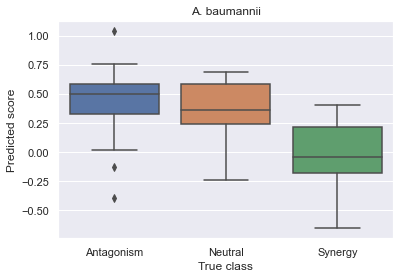

In [5]:
# Load sample data
sample = load_sample('abaumannii')

# Define input arguments
key             = sample['key']
profiles        = sample['profiles']
feature_names   = sample['feature_names']
train_ixns      = sample['train']['interactions']
train_scores    = sample['train']['scores']
test_ixns       = sample['test']['interactions']
test_scores     = sample['test']['scores']
strains         = sample['orthology']['strains']
orthology_map   = sample['orthology']['map']

# Determine ML features
train_data      = featurize(train_ixns, profiles, feature_names=feature_names, key=key, silent=True)
test_data       = featurize(test_ixns, profiles, feature_names=feature_names, key=key, silent=True, 
                            strains=strains, orthology_map=orthology_map)
X_train, X_test = train_data['feature_df'].to_numpy().transpose(), test_data['feature_df'].to_numpy().transpose()

# Determine class labels
thresh, classes = (-0.5, 0), ('S', 'N', 'A')
train_labels    = classify(train_scores, thresholds=thresh, classes=classes)
test_labels     = classify(test_scores, thresholds=thresh, classes=classes)

# Train and apply a regression-based model
reg_model = RandomForestRegressor()
reg_model.fit(X_train, train_scores)
reg_y = reg_model.predict(X_test)
r, p = spearmanr(test_scores, reg_y)
r2 = r2_score(test_scores, reg_y)
print('Regression results:')
print('\tSpearman R = {}'.format(round(r, 4)))
print('\tSpearman p = {:.3g}'.format(p))
print('\tR2 = {}'.format(round(r2, 4)))

# Train and apply a classification-based model
class_model = RandomForestClassifier()
class_model.fit(X_train, train_labels)
class_y = class_model.predict(X_test)
print('Classification results:')
print(classification_report(test_labels, class_y))

# Visualize results
df = pd.DataFrame({'x': test_labels, 'y': reg_y})
df.replace({'A': 'Antagonism', 'N': 'Neutral', 'S': 'Synergy'}, inplace=True)
sns.set(rc={'figure.figsize':(3, 4)})
ax = sns.boxplot(x='x', y='y', data=df, order=['Antagonism', 'Neutral', 'Synergy'], )
ax.set(title='A. baumannii', xlabel='True class', ylabel='Predicted score')
plt.show()

## Extension to CARAMeL: using metabolic flux data as drug profiles

The following example shows how to use metabolic flux data to define the drug profiles, which was introduced in our [CARAMeL algorithm](https://github.com/sriram-lab/CARAMeL). Here we re-run the *E. coli* example using already saved and normalized metabolic flux data (`ecoli_flux_normalized.csv`), which was simulated using the [COBRA Toolbox](https://opencobra.github.io/cobratoolbox/stable/) in [MATLAB](https://www.mathworks.com/products/matlab.html). Please refer to the [CARAMeL publication](https://doi.org/10.1093/pnasnexus/pgac132) for further details.  
- **Training dataset**: 105 two-way interactions between 15 antibiotics  
- **Testing dataset**: 66 two-way interactions between the 15 antibiotics in the training set + 4 new antibiotics  

Defining INDIGO features: 100%|██████████| 66/66 [00:00<00:00, 515.35it/s]


Regression results:
	Spearman R = 0.7238
	Spearman p = 6.57e-12
	R2 = 0.4797
Classification results:
              precision    recall  f1-score   support

           A       0.53      0.69      0.60        13
           N       0.72      0.79      0.75        42
           S       0.67      0.18      0.29        11

    accuracy                           0.67        66
   macro avg       0.64      0.55      0.55        66
weighted avg       0.67      0.67      0.64        66



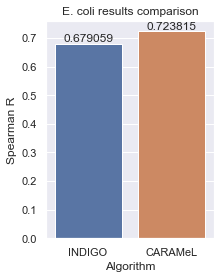

In [6]:
# Load sample data
sample = load_sample('ecoli')

# Define input arguments
key             = sample['key']
train_ixns      = sample['train']['interactions']
train_scores    = sample['train']['scores']
test_ixns       = sample['test']['interactions']
test_scores     = sample['test']['scores']

# Define drug profile information
df              = pd.read_csv('ecoli_flux_normalized.csv')
profiles        = df.loc[:, ~df.columns.isin(['rxn', 'rxnName', 'subSystem'])].to_dict('list')
feature_names   = df['rxn'].tolist()

# Determine ML features
train_data      = featurize(train_ixns, profiles, feature_names=feature_names, key=key, silent=True)
test_data       = featurize(test_ixns, profiles, feature_names=feature_names, key=key, silent=True)
X_train, X_test = train_data['feature_df'].to_numpy().transpose(), test_data['feature_df'].to_numpy().transpose()

# Determine class labels
thresh, classes = (-0.5, 2), ('S', 'N', 'A')
train_labels    = classify(train_scores, thresholds=thresh, classes=classes)
test_labels     = classify(test_scores, thresholds=thresh, classes=classes)

# Train and apply a regression-based model
reg_model = RandomForestRegressor()
reg_model.fit(X_train, train_scores)
reg_y = reg_model.predict(X_test)
r, p = spearmanr(test_scores, reg_y)
r2 = r2_score(test_scores, reg_y)
print('Regression results:')
print('\tSpearman R = {}'.format(round(r, 4)))
print('\tSpearman p = {:.3g}'.format(p))
print('\tR2 = {}'.format(round(r2, 4)))

# Train and apply a classification-based model
class_model = RandomForestClassifier()
class_model.fit(X_train, train_labels)
class_y = class_model.predict(X_test)
print('Classification results:')
print(classification_report(test_labels, class_y))

# Visualize compare INDIGO vs. CARAMeL 
df = pd.DataFrame({'Algorithm': ['INDIGO', 'CARAMeL'], 'Spearman R': [r1, r]})
sns.set(rc={'figure.figsize':(3, 4)})
ax = sns.barplot(x='Algorithm', y='Spearman R', data=df, order=['INDIGO', 'CARAMeL'])
ax.set(title='E. coli results comparison')
ax.bar_label(ax.containers[0])
plt.show()